In [537]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs = pd.read_csv(train_logs_path)
else:
    train_logs = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

In [538]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [539]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [540]:
train_logs.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
2%,69.0,65612.0,65707.0,0.0,27.0,6.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


## Data Analysis

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

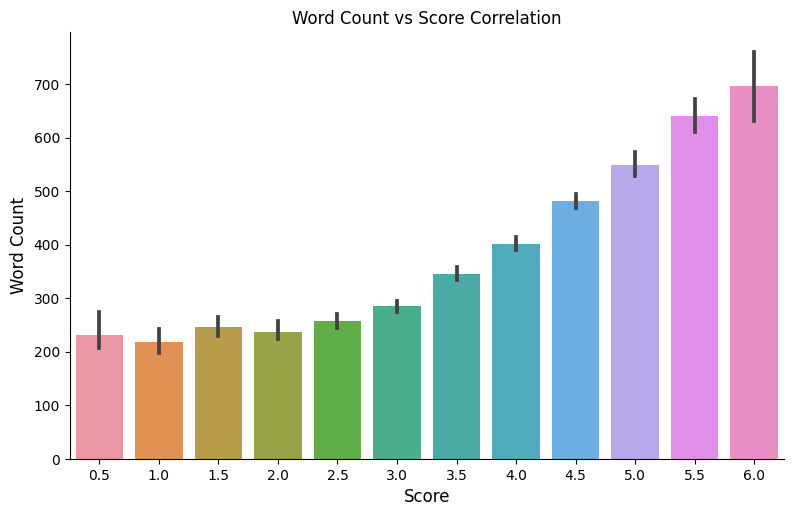

In [541]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [542]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
2%,201.0
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

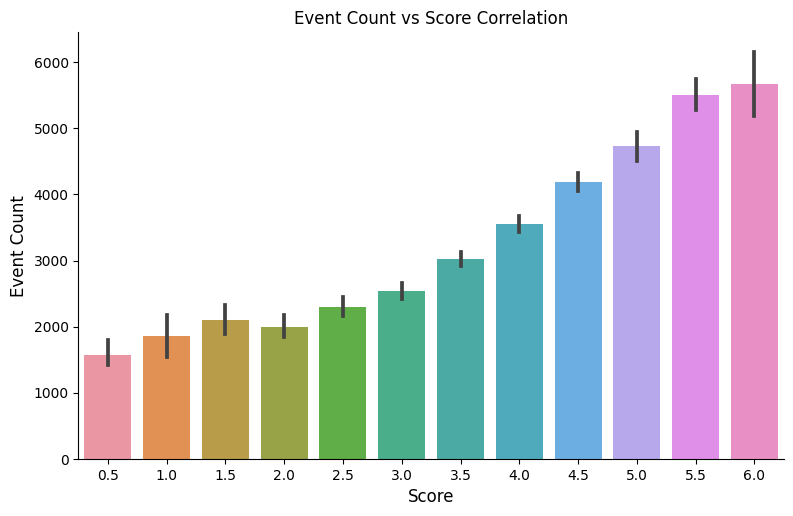

In [543]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [544]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


## Data preprocessing

#### Splitting the ids into training and validation sets.

In [545]:
valid_ids = train_logs["id"].sample(int(train_logs["id"].nunique()*0.2))
train_ids = np.setdiff1d(train_logs["id"], valid_ids)

#### Calculating values to consitently normalization and outlier removeal

In [546]:
# Removal of lines above these numbers.
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
MAX_ACTION_DURATION = 250 # Based on 99th percentile.

# TOP is the value all the other values are divided by to the vast majority of the data from [0, 1]
WORD_COUNT_TOP = 850 # Based on 98th percentile.
CURSOR_POSITION_TOP = 4000 # Based on the 99th percentile.

#### Removing outliers

In [547]:
train_logs.drop(train_logs[train_logs.down_time > MAX_EVENT_START_TIME].index, inplace=True)
train_logs.drop(train_logs[train_logs.action_time > MAX_ACTION_DURATION].index, inplace=True)

#### Converting to an image

In [548]:
NUMBER_OF_INTERVALS = 7_200 # 7_200 = 1_800_000 msec / 0.25 second intervals

def EssayToImage(df: pd.DataFrame) -> pd.DataFrame:
    """Converts an essay into an "image". Aka, a dataframe with 8 columns and rows equal to NUMBER_OF_INTERVALS. Note, for speed reasons, this will drop some columns.

    Args:
        df (pd.DataFrame): The dataframe of a SINGLE ID to input.

    Returns:
        pd.DataFrame: The resulting dataframe.
    """
    nonproduction = np.zeros(NUMBER_OF_INTERVALS)
    input = np.zeros(NUMBER_OF_INTERVALS)
    remove = np.zeros(NUMBER_OF_INTERVALS)
    paste = np.zeros(NUMBER_OF_INTERVALS)
    replace = np.zeros(NUMBER_OF_INTERVALS)
    move = np.zeros(NUMBER_OF_INTERVALS)
    cursor = np.zeros((NUMBER_OF_INTERVALS, 1))
    words = np.zeros(NUMBER_OF_INTERVALS)

    for index, row in df.iterrows():
        down_index = int(row.down_time / NUMBER_OF_INTERVALS)
        up_index = int(row.down_time / NUMBER_OF_INTERVALS) + 1 # + 1 makes the switch case cleaner
        action = row.activity

        np.append(cursor[up_index-1], row.cursor_position / CURSOR_POSITION_TOP)
        if words[down_index:up_index] < row.word_count / WORD_COUNT_TOP:
            words[down_index:up_index] = row.word_count / WORD_COUNT_TOP

        match action:
            case "Nonproduction":
                nonproduction[down_index:up_index] += 1
            case "Input":
                input[down_index:up_index] += 1
            case "Remove/Cut":
                remove[down_index:up_index] += 1
            case "Paste":
                paste[down_index:up_index] += 1
            case "Replace":
                replace[down_index:up_index] += 1
            case _:
                if "Move From" in action:
                    move[down_index:up_index] += 1
    
    cursor = np.delete(cursor, 0).mean()
    return pd.DataFrame({
        "nonproduction" : nonproduction,
        "input" : input,
        "remove": remove,
        "paste": paste,
        "replace": replace,
        "move": move,
        "cursor": cursor,
        "word_count": words
    })
                

testImage = EssayToImage(train_logs[train_logs["id"] == train_ids[0]])

In [549]:
train_dfs = {}
for index in train_ids:
    train_dfs[index] = EssayToImage(train_logs[train_logs["id"] == index])

print(train_dfs[train_ids[0]])

      nonproduction  input  remove  paste  replace  move  cursor  word_count
0               1.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
1               0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
2               1.0    3.0     0.0    0.0      0.0   0.0     0.0    0.001176
3               1.0   44.0     0.0    0.0      0.0   0.0     0.0    0.009412
4               1.0    6.0     0.0    0.0      0.0   0.0     0.0    0.010588
...             ...    ...     ...    ...      ...   ...     ...         ...
7195            0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
7196            0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
7197            0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
7198            0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000
7199            0.0    0.0     0.0    0.0      0.0   0.0     0.0    0.000000

[7200 rows x 8 columns]


In [550]:
scores_dict = {}
for id in train_ids:
    scores_dict[id] = train_scores[train_scores["id"] == id]["score"]

In [551]:
def OneHotEncoding(n: float):
    result = [0]*12
    result[int(n / 0.5) - 1] = 1
    return result

x_train = np.empty(shape=len(train_ids), dtype=type([[]]))
y_train = np.empty(shape=len(train_ids), dtype=type(np.array([])))

for index, id in enumerate(train_ids):
    x_train[index] = np.array(train_dfs[id].values.tolist())
    y_train[index] = OneHotEncoding(scores_dict[id])

/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_64286/1627860570.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  result[int(n / 0.5) - 1] = 1


In [552]:
print(x_train[0])
print(y_train[0])
print(x_train[0].shape)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 3.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.17647059e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
(7200, 8)


In [560]:
valid_dfs = {}
for index in valid_ids:
    valid_dfs[index] = EssayToImage(train_logs[train_logs["id"] == index])

x_valid = np.empty(shape=len(valid_ids), dtype=type([[]]))
y_valid = np.empty(shape=len(valid_ids), dtype=type(np.array([])))

for index, id in enumerate(valid_ids):
    x_valid[index] = np.array(valid_dfs[id].values.tolist())
    y_valid[index] = OneHotEncoding(scores_dict[id])

In [563]:
input_shape = (len(train_ids), x_train[0].shape[0], x_train[0].shape[1])
print(input_shape[1:])
model = models.Sequential()
model.add(layers.Conv1D(32, 3, input_shape=input_shape[1:], activation='relu'))
model.add(layers.MaxPooling1D(6))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(4))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024,activation='relu'))
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=12,activation='relu'))


(7200, 8)


In [554]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 7198, 32)          800       
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 1199, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 1197, 64)          6208      
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 299, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 297, 64)           12352     
                                                                 
 flatten_2 (Flatten)         (None, 19008)           

In [557]:
strategy = tf.distribute.MirroredStrategy(devices=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [579]:
#with strategy.scope():
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [580]:
#with strategy.scope():
model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
# results = model.evaluate(x_valid, y_valid)
# for a in range(len(results)):
#     print(f"{model.metrics_names[a]}: {results[a]:.3f}")

# predictions: np.array = model.predict(x_valid)
# scaled_Pred = []
# for p in predictions:
#     max = p.max()
#     scaled_Pred.append(np.array([1 if x == max else 0 for x in p]))


In [ ]:
# Generate the submission
test_data = FeatureEngineering(test_logs)
test_data = NormalizeTrainData(test_data)
predictions = []
for index, row in test_data.iterrows():
    x_data = [x for x in row[1:]]
    pred = model.predict([x_data])
    max = pred[0].max()
    pred = [1 if x == max else 0 for x in pred[0]]
    result = 0.5
    for index, p in enumerate(pred):
        if p == 1:
            result = 0.5 * index + 0.5
    
    predictions.append((row[0], result)) # (Id, result)
print(predictions)

In [ ]:
ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]
# ids = [1, 2, 3]
# scores = [0.5, 3.0, 4.5]
sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)